# 機械学習
## アルゴリズム
※その他のアルゴリズムを紹介。  
具体的には、knnとk-means

- knn  
判別したい点に対して、最近傍の点をk個とってきて、それらが最も多く所属するクラスに識別する。  
当然、kを変えると結果も変わる。

以下、模擬データを作って、k近傍法の実践を行う。

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

In [7]:
class generator():
    def __init__(self,size):
        self.size = size

    def gen_data(self):
        x0 = np.random.normal(size=self.size).reshape(-1,2) -1
        x1 = np.random.normal(size=self.size).reshape(-1,2) +1
        x_train = np.concatenate([x0,x1])
        y_train = np.concatenate([np.zeros(math.floor(self.size/2)), np.ones(math.ceil(self.size/2))]).astype(np.int)
        return x_train, y_train

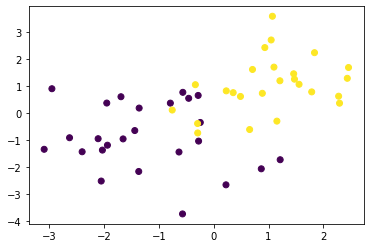

In [10]:
X_train, ys_train = generator(50).gen_data()
plt.scatter(X_train[:, 0], X_train[:,1], c=ys_train)

In [45]:
class my_knn():
    def __init__(self, n_neighbors, x_train, y_train):
        self.n_neighbors = n_neighbors
        self.x_train = x_train
        self.y_train = y_train
    
    # 正確には距離の2乗だが、sortに使うだけなので影響はない。
    def distance(self, x1, x2):
        return np.sum((x1-x2)**2, axis = 1)
    
    def knc_predict(self, X_test):
        self.X_test = X_test
        self.y_pred = np.empty(len(X_test), dtype=self.y_train.dtype)
        for i, x in enumerate(X_test):
            distances = self.distance(x, self.x_train)
            nearest_index = distances.argsort()[:self.n_neighbors]
            mode, _ = stats.mode(self.y_train[nearest_index])
            self.y_pred[i] = mode
        return self.y_pred
    
    def plt_result(self):
        xx0, xx1 = np.meshgrid(np.linspace(-5,5,100), np.linspace(-5,5,100))
        xx = np.array([xx0, xx1]).reshape(2,-1).T
        plt.scatter(self.x_train[:,0], self.x_train[:,1], c = self.y_train)
        plt.contour(xx0,xx1,self.knc_predict(xx).reshape(100,100).astype(dtype=np.float), alpha=0.2, levels=np.linspace(0,1,3))

In [18]:
Knn = my_knn(n_neighbors = 3, x_train = X_train, y_train = ys_train)

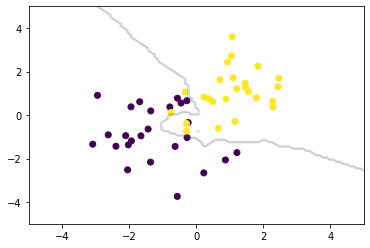

In [19]:
Knn.plt_result()

- k-means  
特徴の似ているものをひとまとめにする。グルーピングを行う。  
教師なし学習。

- k-meansの手順  
 1. 各クラスタの中心の初期値を設定する。  
 2. 各点に対して、クラスタ中心との距離を計算し、クラスの再割り当てを行う。  
 3. 各クラスタの中心を再計算する。  
 4. 2,3のプロセスを繰り返す。  

- 注意点  
初期値が近いと、うまくクラスタリングできない場合がある。  
kの値は分析者が決めないといけない。

### 実装  
以下、k-meansをとりあえずirisで試す。

In [98]:
from sklearn.datasets import load_iris

In [99]:
iris = load_iris()
# petal lengthとpetal widthを使用する。
X_iris = iris.data[:,[2,3]]

# ｙも一応描写時に使うので設定しておく（k-means本体では使わない）
y_iris = iris.target.reshape(-1,1)

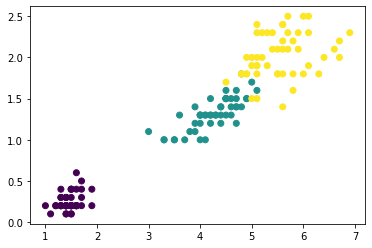

In [100]:
# 描写
plt.scatter(X_iris[:,0], X_iris[:,1], c = y_iris)

※ メモ  
今回、一応 k = 3とするが、yが未知の場合は、2クラスの方が良いかも。

In [119]:
class KmeansClassifier():
    def __init__(self, n_clusters, iter_max):
        self.n_clusters = n_clusters
        self.iter_max = iter_max
    
    def __distance(self, x1, x2):
        return np.sum((x1 - x2) ** 2, axis = 1)
    
    def classify(self, X_train):
        self.X_train = X_train
        self.centers = self.X_train[np.random.choice(len(self.X_train), self.n_clusters, replace=False)]
        
        for _ in range(iter_max):
            prev_centers = np.copy(self.centers)
            D = np.zeros((len(X_train),self.n_clusters))
            for i, x in enumerate(self.X_train):
                D[i] = self.__distance(x, self.centers)
            cluster_index = np.argmin(D, axis=1)
            for k in range(self.n_clusters):
                index_k = cluster_index == k
                self.centers[k] = np.mean(self.X_train[index_k], axis = 0)
            if np.allclose(prev_centers, self.centers):
                break
        self.y_pred = np.empty(len(self.X_train), dtype=int)
        for i, x in enumerate(self.X_train):
            d = self.__distance(x, self.centers)
            self.y_pred[i] = np.argmin(d)
                
    def plt_result(self):
        x0_min = np.min(self.X_train[:,0])
        x0_max = np.max(self.X_train[:,0])
        x0_width = x0_max - x0_min
        x1_min = np.min(self.X_train[:,1])
        x1_max = np.max(self.X_train[:,1])
        x1_width = x1_max - x1_min
        xx0, xx1 = np.meshgrid(np.linspace(x0_min - x0_width/20, x0_max + x0_width/20 ,100), np.linspace(x1_min - x1_width/20, x1_max + x1_width/20 ,100))
        xx = np.array([xx0,xx1]).reshape(2,-1).T
        plt.scatter(self.X_train[:,0], self.X_train[:,1], c = self.y_pred, cmap = "spring")
        plt.scatter(self.centers[:,0], self.centers[:,1], s = 200, marker="x", lw=2, c = "black", edgecolor = "white")
        pred = np.empty(len(xx), dtype=int)
        for i, x in enumerate(xx):
            d = self.__distance(x, self.centers)
            pred[i] = np.argmin(d)
        plt.contour(xx0, xx1, pred.reshape(100,100), alpha=0.2, cmap="spring")

In [120]:
n_clusters = 3
iter_max = 100

KC = KmeansClassifier(n_clusters = n_clusters, iter_max = iter_max)
KC.classify(X_iris)

In [121]:
KC.centers

array([[5.59583333, 2.0375    ],
       [4.26923077, 1.34230769],
       [1.462     , 0.246     ]])

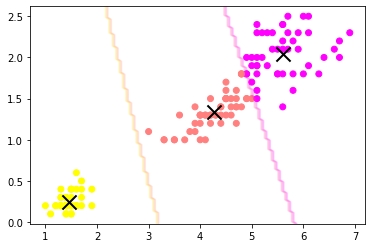

In [122]:
KC.plt_result()
plt.show()

また、分類を2クラス、4クラスとした場合は下のようになる。

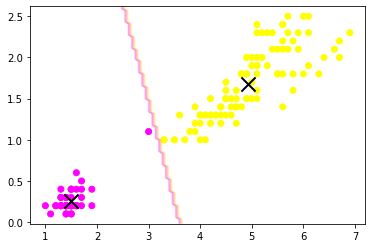

In [124]:
KC2 = KmeansClassifier(n_clusters=2, iter_max = iter_max)
KC2.classify(X_iris)
KC2.plt_result()
plt.show()

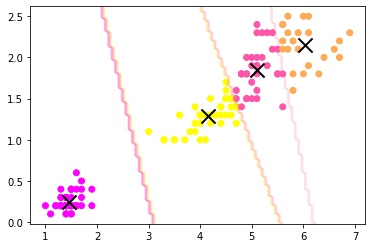

In [125]:
KC3 = KmeansClassifier(n_clusters=4, iter_max = iter_max)
KC3.classify(X_iris)
KC3.plt_result()
plt.show()

真の分類y_irisから見ると、3クラスに分類したものは、それなりの制度になっているのがわかる。  
一方で、真の分類に対する他の前情報が一切ない場合には、2～4の分類のどれを採用するかは、直面している解決すべき問題による。

また、上記分析を用いて、疑似的に作成したモデルデータの解析も行う。

In [126]:
class data_maker_for_kmeans():
    def __init__(self, size):
        self.size = size
    
    def gen_data(self):
        self.x1 = np.random.normal(size=(self.size, 2))+np.array([-5,-5])
        self.x2 = np.random.normal(size=(self.size, 2))+np.array([5,-5])
        self.x3 = np.random.normal(size=(self.size, 2))+np.array([0,5])
        return np.vstack((self.x1, self.x2, self.x3))

In [127]:
DMforK = data_maker_for_kmeans(100)
X_generated = DMforK.gen_data()

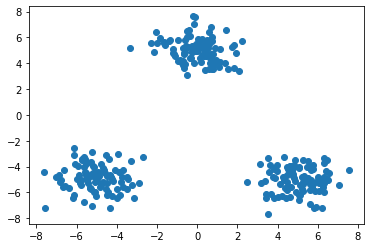

In [128]:
plt.scatter(X_generated[:,0],X_generated[:,1])

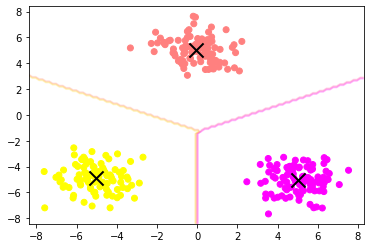

In [130]:
KC_for_gen = KmeansClassifier(n_clusters=3, iter_max = iter_max)
KC_for_gen.classify(X_generated)
KC_for_gen.plt_result()
plt.show()